In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

# Obj: Predict whether or not a person survive the titanic disaster using certain features in the titanic dataset

Inspired by [this](https://www.linkedin.com/pulse/what-i-learned-analyzing-famous-titanic-dateset-murilo-gustineli/) post on linkedin : 

#### My original contribution:<br>
##### Exploratory Data Analysis
- I add some insights in the EDA and reword some of the existing insight
- I change the formatting of the graphs to what I view to be more readable

##### Feature Engineering
- I simplify the feature engineering steps
- I automate the feature engineering process using sklearn's Pipeline API

##### Modelling
- I try to make the model selection more "robust" by using kfold
- I try testing and using different models

##### Kaggle Result
My best result is 0.7799, which is not that impressive hahaha, but ill take it

#### Reading the training data

In [5]:
df = pd.read_csv("../datasets/train.csv")

## Exploratory Data Analysis

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [19]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### Detecting the outlier in the fare column

In [20]:
df[df["Fare"]==df["Fare"].max()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


#### Correlation heatmap between numerical features

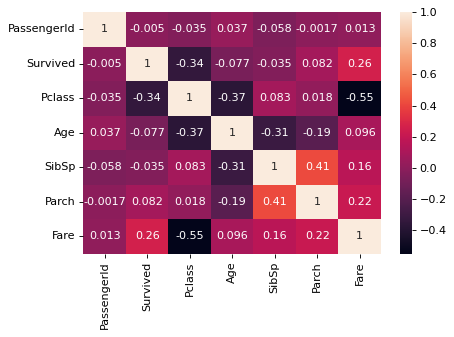

In [21]:
fig, ax = plt.subplots(dpi=80)

sns.heatmap(df.corr(numeric_only=True), annot=True, ax=ax)
plt.show()

- There is a moderate positive correlation between SibSp (number of sibling) and Parch (number of parent)
- There is a moderate negative correlation between Fare and Pclass

#### survivability based on title

C:\Users\USER\AppData\Local\Temp\ipykernel_5884\4173807647.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_title.index, rotation = 50)


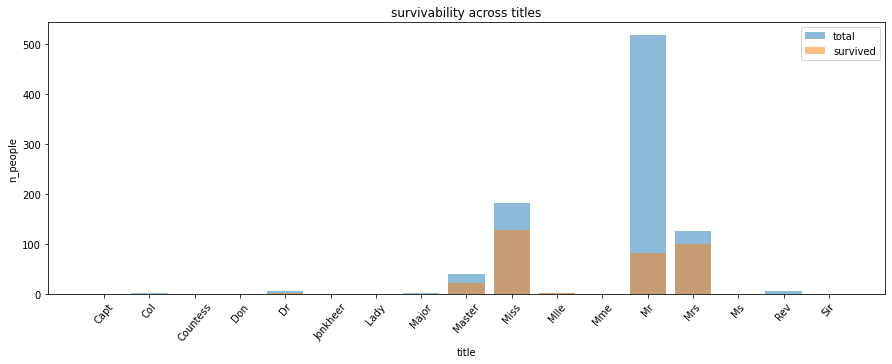

In [22]:
df_title = df.copy()
df_title["titles"] = df["Name"].str.extract(' ([A-Za-z]+)\.')  # Regex created by ChatGPT :p

df_title = df_title.groupby("titles")["Survived"].agg(["count", "sum", "mean"])

fig, ax = plt.subplots(figsize=(15,5))
ax.bar(df_title.index, df_title["count"], alpha=0.5, label="total")
ax.bar(df_title.index, df_title["sum"], alpha=0.5, label="survived")
ax.set_xticklabels(df_title.index, rotation = 50)
ax.set_xlabel("title")
ax.set_ylabel("n_people")
ax.set_title("survivability across titles")
ax.legend()
plt.show()

- Passengers with Mr title is least likely to survive
- Passengener with Miss and Mrs titile have a relatively high chance of surviving
- Passengers with Master as title have 50-50 survival chance
- Other titles are somewhat insignificant in number

#### survivability based on sex

In [23]:
sex = df.groupby("Sex")["Survived"].agg(["count", "sum", "mean"])
sex["mean"] = sex["mean"] * 100
sex = sex.rename({"count":"n_pass", "sum":"n_survived", "mean":"%_survived"}, axis="columns")
sex

,n_pass,n_survived,%_survived
Sex,,,
female,314,233,74.203822
male,577,109,18.890815


- female has significantly larger chance of survival
- sex will have high collinearity with title

#### Survivability based on age

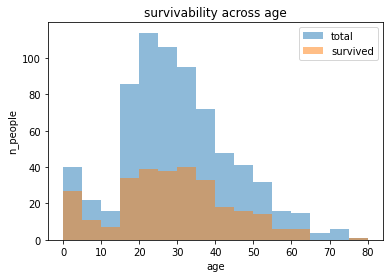

In [24]:
fig, ax = plt.subplots()
survived = df[df["Survived"]==1]
ax.hist(df["Age"], bins=np.arange(0, 81, 5), alpha=0.5, label="total")
ax.hist(survived["Age"], bins=np.arange(0, 81, 5), alpha=0.5, label="survived")
ax.set_xlabel("age")
ax.set_ylabel("n_people")
ax.set_title("survivability across age")
ax.legend()
plt.show()

- Passengers aged 0-15 has the highest probability of surviving
- Passengers aged 16-40 has the lowest probability of surviving
- Passengers aged 41-65 is somewhere in the middle
- Passengers aged 66-80 has pretty low probability of surviving

#### Survivability based on fares

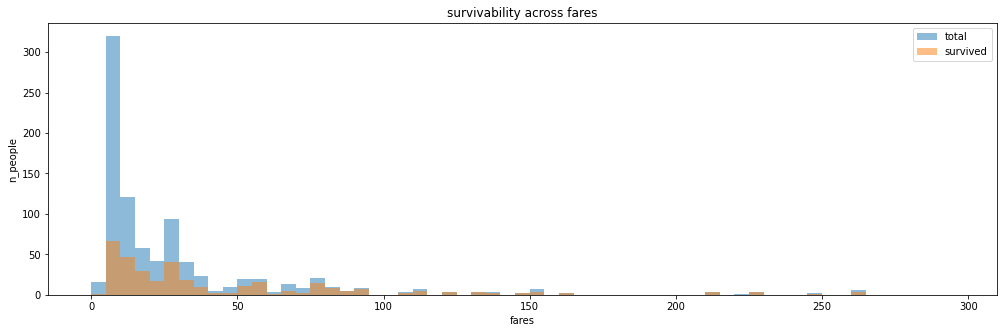

In [25]:
fig, ax = plt.subplots(figsize=(17,5))
survived = df[df["Survived"]==1]
ax.hist(df["Fare"], alpha=0.5, bins=np.arange(0, 300, 5), label="total")
ax.hist(survived["Fare"], alpha=0.5, bins=np.arange(0, 300, 5), label="survived")
ax.set_xlabel("fares")
ax.set_ylabel("n_people")
ax.set_title("survivability across fares")
ax.legend()
plt.show()

- passengers with fare 0-15 has the lowest probabilty of surviving
- passengers with fare 16-40 has modest probabilty of surviving
- passengers with fare >41 has quite high probability of surviving

#### Survivability based on sex and age

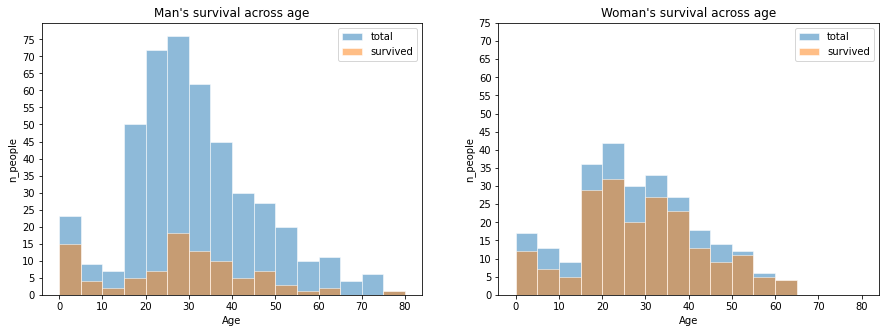

In [26]:
man = df[df["Sex"]=="male"]
woman = df[df["Sex"]=="female"]

survived_man = man[man["Survived"]==1]
survived_woman = woman[woman["Survived"]==1]

fig, ax = plt.subplots(1,2, figsize=(15, 5))

ax[0].hist(man["Age"], alpha=0.5, bins=np.arange(0, 81, 5), label="total", edgecolor = "white")
ax[0].hist(survived_man["Age"], alpha=0.5, bins=np.arange(0, 81, 5), label="survived", edgecolor = "white")
ax[0].set_yticks(np.arange(0, 80, 5))
ax[0].set_title("Man's survival across age")
ax[0].set_xlabel("Age")
ax[0].set_ylabel("n_people")
ax[0].legend()

ax[1].hist(woman["Age"], alpha=0.5, bins=np.arange(0, 81, 5), label="total", edgecolor = "white")
ax[1].hist(survived_woman["Age"], alpha=0.5, bins=np.arange(0, 81, 5), label="survived", edgecolor = "white")
ax[1].set_yticks(np.arange(0, 80, 5))
ax[1].set_title("Woman's survival across age")
ax[1].set_xlabel("Age")
ax[1].set_ylabel("n_people")
ax[1].legend()

plt.show()

- There is interaction between age and sex, specifically men who are of the age 0-15 are much more likely to survive compared to other men

#### survivability based on embarkation

In [27]:
emb = df.groupby("Embarked")["Survived"].agg(["count", "sum", "mean"])
emb["mean"] = emb["mean"] * 100
emb = emb.rename({"count":"n_pass", "sum":"n_survived", "mean":"%_survived"}, axis="columns")
emb

,n_pass,n_survived,%_survived
Embarked,,,
C,168,93,55.357143
Q,77,30,38.961039
S,644,217,33.695652


- embarkation from C does not seem to give much information

#### survivability based on cabin

In [28]:
df_cab = df.copy()
df_cab["Cabin_strip"] = df["Cabin"].str[0]
df_cab = df_cab.groupby("Cabin_strip")["Survived"].agg(["count", "sum", "mean"])
df_cab["mean"] = df_cab["mean"] * 100
df_cab = df_cab.rename({"count":"n_pass", "sum":"n_survived", "mean":"%_survived"}, axis="columns")
df_cab

,n_pass,n_survived,%_survived
Cabin_strip,,,
A,15,7,46.666667
B,47,35,74.468085
C,59,35,59.322034
D,33,25,75.757576
E,32,24,75.000000
F,13,8,61.538462
G,4,2,50.000000
T,1,0,0.000000


- I dont think that its worth imputing that many missing values for this little information

### survivability based on ses class

In [29]:
ses_class = df.groupby("Pclass")["Survived"].agg(["count", "sum", "mean"])
ses_class["mean"] = ses_class["mean"] * 100
ses_class = ses_class.rename({"count":"n_pass", "sum":"n_survived", "mean":"%_survived"}, axis="columns")
ses_class

,n_pass,n_survived,%_survived
Pclass,,,
1,216,136,62.962963
2,184,87,47.282609
3,491,119,24.236253


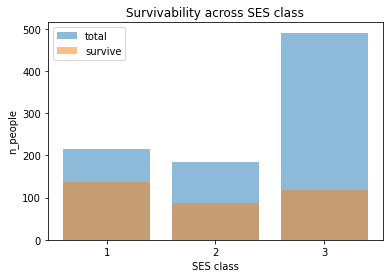

In [30]:
fig, ax = plt.subplots()
class_ = ses_class.index

ax.bar(ses_class.index, ses_class["n_pass"], alpha=0.5, label="total")
ax.bar(ses_class.index, ses_class["n_survived"], alpha=0.5, label="survive")
ax.set_xticks(ses_class.index)
ax.set_xlabel("SES class")
ax.set_ylabel("n_people")
ax.set_title("Survivability across SES class")
ax.legend()

plt.show()

- Rich people tend to survive ofc =D

## Feature Engineering & Data Cleaning (1)

##### Imputing missing values
The features age and embarked need to be imputed with its central measure (mean for numerical and mode for categorical)

##### Extract title from name
The feature name contains title, which might come in handy

##### One hot encoding
The categorical features Sex, Embarked, and title

##### Combining the SibSp and Parch features
Due to their moderate correlation, SibSp and Parch should be summed to create just one feature

#### Binning features
To avoid overfitting, the features age and fares should be binned based on its effect on survival

##### Dropping unecessary features
Dropping 
- PassengerId (obvious)
- Cabin (too many missing values)
- Name, Ticket, Embarked, SibSp, Parch, "title" (features already extracted) 
- "C" (does not give significant information, a liability for overfittng)


If you want to use custom transformer (e.g. dropping and combining features), you should create your own class

In [168]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,StandardScaler, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin

class Imputer(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()  # To prevent the estimators from changing the data in-place
        age_imputer = SimpleImputer(strategy="mean")
        X["Age"] = age_imputer.fit_transform(X[["Age"]])
        fare_imputer = SimpleImputer(strategy="mean")
        X["Fare"] = fare_imputer.fit_transform(X[["Fare"]])
        X["Embarked"] = X["Embarked"].fillna(X["Embarked"].mode()[0])
        return X
    
class ExtractFeature(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        title = X["Name"].str.extract(' ([A-Za-z]+)\.')
        title[(title!="Miss") & (title!="Mr") & (title!="Mrs") & (title!="Master") ] = "Other"
        X["Title"] = title
        return X

class Encoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        emb_encoder = OneHotEncoder(handle_unknown="ignore")
        
        emb_encoded = emb_encoder.fit_transform(X[["Embarked"]]).toarray()
        for i, j in enumerate(emb_encoder.categories_[0]):
            X[j] = emb_encoded[:, i]
        
        X["Sex"] = X["Sex"].replace({"male":1, "female":0})
        
        tit_encoder = OneHotEncoder(handle_unknown="ignore")
        tit_encoded = tit_encoder.fit_transform(X[["Title"]]).toarray()
        for i, j in enumerate(tit_encoder.categories_[0]):
            X[j] = tit_encoded[:, i]
        
        return X
            
class CombineFeature(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X["Relative"] = X["SibSp"] + X["Parch"]
        return X
    
class BinningFeature(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        age = X["Age"].copy()
        age[age <= 15] = 1
        age[(age > 15) & (age <= 40)] = 2
        age[(age > 40 )& (age <= 65)] = 3
        age[age > 65] = 4
        X["Age"] = age
        
        fare = X["Fare"].copy()
        fare[fare <= 15] = 1
        fare[(fare > 15) & (fare <= 40)] = 2
        fare[fare > 40] = 3
        X["Fare"] = fare
        return X

class FeatureDropper(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(["PassengerId", "Name", "Ticket", "Cabin", "Embarked", "SibSp", 
                       "Parch", "Title", "C"], axis=1)

remember that the built-in estimator uses numpy array, not pandas

In [169]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("imputer", Imputer()),
    ("extract_feature", ExtractFeature()),
    ("encoder", Encoder()),
    ("binning_feature", BinningFeature()),
    ("combine_feature", CombineFeature()),
    ("feature_dropper", FeatureDropper())
])

In [170]:
df_clean = pipe.fit_transform(df)

## Model selection

In [171]:
X = df_clean.loc[:, df_clean.columns!="Survived"]
y = df_clean["Survived"]

### Preliminary modelling for selection

I will be selecting one model from these arbitrarily picked 5 models. 
- Logistic regression
- Naive bayes
- Decision tree
- Random forest
- XGBoost

In [104]:
from sklearn.model_selection import KFold, cross_val_score
cv = KFold(shuffle=True)

#### Logistic regression

In [119]:
from sklearn.linear_model import LogisticRegression

train_scores = []
test_scores = []
for i, j in cv.split(X):
    X_train = X.iloc[i,:]
    y_train = y[i]
    X_test = X.iloc[j,:]
    y_test = y[j]
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    train_scores.append(logreg.score(X_train, y_train))
    test_scores.append(logreg.score(X_test, y_test))
print(f"train_scores : {train_scores}")
print(f"test_scores : {test_scores}")
print(f"mean_train_scores: {np.array(train_scores).mean()}")
print(f"mean_test_scores: {np.array(test_scores).mean()}")

    

train_scores : [0.8286516853932584, 0.8260869565217391, 0.8218793828892006, 0.8330995792426368, 0.8429172510518934]
test_scores : [0.8435754189944135, 0.848314606741573, 0.8539325842696629, 0.8089887640449438, 0.7640449438202247]
mean_train_scores: 0.8305269710197457
mean_test_scores: 0.8237712635741635


#### Gaussian Naive Bayes

In [120]:
from sklearn.naive_bayes import GaussianNB

train_scores = []
test_scores = []
for i, j in cv.split(X):
    X_train = X.iloc[i,:]
    y_train = y[i]
    X_test = X.iloc[j,:]
    y_test = y[j]
    nb = GaussianNB()
    nb.fit(X_train, y_train)
    train_scores.append(nb.score(X_train, y_train))
    test_scores.append(nb.score(X_test, y_test))
print(f"train_scores : {train_scores}")
print(f"test_scores : {test_scores}")
print(f"mean_train_scores: {np.array(train_scores).mean()}")
print(f"mean_test_scores: {np.array(test_scores).mean()}")

train_scores : [0.7837078651685393, 0.7952314165497896, 0.7966339410939691, 0.7980364656381487, 0.7994389901823282]
test_scores : [0.8324022346368715, 0.7696629213483146, 0.8258426966292135, 0.797752808988764, 0.7359550561797753]
mean_train_scores: 0.7946097357265549
mean_test_scores: 0.7923231435565878


#### Decision tree

multiple parameters were manually tested because leaving them as is will almost guarantee overfitting

In [121]:
from sklearn.tree import DecisionTreeClassifier

train_scores = []
test_scores = []
for i, j in cv.split(X):
    X_train = X.iloc[i,:]
    y_train = y[i]
    X_test = X.iloc[j,:]
    y_test = y[j]
    dec = DecisionTreeClassifier(max_depth=3)
    dec.fit(X_train, y_train)
    train_scores.append(dec.score(X_train, y_train))
    test_scores.append(dec.score(X_test, y_test))
print(f"train_scores : {train_scores}")
print(f"test_scores : {test_scores}")
print(f"mean_train_scores: {np.array(train_scores).mean()}")
print(f"mean_test_scores: {np.array(test_scores).mean()}")

train_scores : [0.8384831460674157, 0.8246844319775596, 0.8260869565217391, 0.8176718092566619, 0.8302945301542777]
test_scores : [0.8212290502793296, 0.8370786516853933, 0.8146067415730337, 0.848314606741573, 0.797752808988764]
mean_train_scores: 0.8274441747955308
mean_test_scores: 0.8237963718536188


#### Random forest

multiple parameters were manually tested because leaving them as is will almost guarantee overfitting

In [173]:
from sklearn.ensemble import RandomForestClassifier

train_scores = []
test_scores = []
for i, j in cv.split(X):
    X_train = X.iloc[i,:]
    y_train = y[i]
    X_test = X.iloc[j,:]
    y_test = y[j]
    ranfor = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_split=4)
    ranfor.fit(X_train, y_train)
    train_scores.append(ranfor.score(X_train, y_train))
    test_scores.append(ranfor.score(X_test, y_test))
print(f"train_scores : {train_scores}")
print(f"test_scores : {test_scores}")
print(f"mean_train_scores: {np.array(train_scores).mean()}")
print(f"mean_test_scores: {np.array(test_scores).mean()}")

train_scores : [0.8314606741573034, 0.8359046283309958, 0.8415147265077139, 0.8359046283309958, 0.8429172510518934]
test_scores : [0.88268156424581, 0.8089887640449438, 0.8146067415730337, 0.8426966292134831, 0.8033707865168539]
mean_train_scores: 0.8375403816757805
mean_test_scores: 0.8304688971188249


#### Xtreme gradient boosting

multiple parameters were manually tested because leaving them as is will almost guarantee overfitting

In [123]:
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')  # the warning in xgboost is too annoying :p

train_scores = []
test_scores = []
for i, j in cv.split(X):
    X_train = X.iloc[i,:]
    y_train = y[i]
    X_test = X.iloc[j,:]
    y_test = y[j]
    xgboost = XGBClassifier(n_estimators=7, max_depth=5, gamma=2)
    xgboost.fit(X_train, y_train)
    train_scores.append(xgboost.score(X_train, y_train))
    test_scores.append(xgboost.score(X_test, y_test))
print(f"train_scores : {train_scores}")
print(f"test_scores : {test_scores}")
print(f"mean_train_scores: {np.array(train_scores).mean()}")
print(f"mean_test_scores: {np.array(test_scores).mean()}")

train_scores : [0.8567415730337079, 0.8316970546984572, 0.8330995792426368, 0.8429172510518934, 0.8401122019635343]
test_scores : [0.7597765363128491, 0.8370786516853933, 0.8539325842696629, 0.8202247191011236, 0.8202247191011236]
mean_train_scores: 0.8409135319980459
mean_test_scores: 0.8182474420940306


#### Model comparison result

Random forest appears to have the edge with xgboost trailing not far behind (with multiple runs, random forest appears to be more stable)

#### testing random forest on whole data (1)

In [174]:
ranfor = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_split=4)
ranfor.fit(X, y)
print(ranfor.score(X, y))

0.8395061728395061


#### See if some features can be eliminated using xgboost's feature importance

In [175]:
xgboost = XGBClassifier(n_estimators=7, max_depth=5, gamma=2)
xgboost.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=7, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [176]:
fet_import = pd.DataFrame(np.hstack((X.columns.values.reshape(-1, 1), 
                          xgboost.feature_importances_.reshape(-1 ,1))), 
                          columns=["feature", "importance"])
fet_import.sort_values("importance", ascending=False)

,feature,importance
8,Mr,0.625099
0,Pclass,0.086762
10,Other,0.081764
11,Relative,0.075775
5,S,0.035079
1,Sex,0.031442
2,Age,0.025801
4,Q,0.023187
3,Fare,0.01509
6,Master,0.0


Master, Miss, and Mrs has no feature importance, hence shall be eliminated

### Feature engineering & data cleaning (2)

Taking into account the discovery found during feature importance testing by updating the FeatureDropper class

In [31]:
class FeatureDropper2(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(["PassengerId", "Name", "Ticket", "Cabin", "Embarked", "SibSp", 
                       "Parch", "Title", "C", "Master", "Miss", "Mrs"], axis=1)  # add dropped columns

In [33]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("imputer", Imputer()),
    ("extract_feature", ExtractFeature()),
    ("encoder", Encoder()),
    ("binning_feature", BinningFeature()),
    ("combine_feature", CombineFeature()),
    ("feature_dropper", FeatureDropper2())
])

In [34]:
df_clean = pipe.fit_transform(df)
X = df_clean.loc[:, df_clean.columns!="Survived"]
y = df_clean["Survived"]

#### testing random forest on whole data (2)

In [36]:
from sklearn.ensemble import RandomForestClassifier

ranfor = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_split=4)
ranfor.fit(X, y)
print(ranfor.score(X, y))

0.8383838383838383


just as good as before.

### Submission testing

when I submit the above model to kaggle, I got __0.7799__ accuracy

### Tuning the random forest using RandomizedSearchCV

In [62]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

param_dist = {"max_depth": [3, 4, 5], 
              "max_features": sp_randint(1, 11), 
              "min_samples_split": sp_randint(2, 11), 
              "bootstrap": [True, False], 
              "criterion": ["gini", "entropy"]} 

ranfor = RandomForestClassifier(n_estimators=10)  # 10 estimators should be plenty
random_search = RandomizedSearchCV(ranfor, param_distributions=param_dist, 
                                   n_iter=20, cv=5, return_train_score=True)
random_search.fit(X, y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(n_estimators=10),
                   n_iter=20,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 4, 5],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000017158CD5A00>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000017158CD0760>},
                   return_train_score=True)

#### Best parameters according to RandomizedSearchCV

In [63]:
random_search.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=4, max_features=5,
                       min_samples_split=6, n_estimators=10)

#### Cross validation result for RandomizedSearchCV

best_estimator_ is found based on the mean of test_score obtained on each fold

In [64]:
df_cv = pd.DataFrame(random_search.cv_results_).sort_values("rank_test_score").head()
df_cv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_max_features,param_min_samples_split,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.032582,0.003708,0.007941,0.001052,False,gini,4,5,6,"{'bootstrap': False, 'criterion': 'gini', 'max...",...,0.832741,0.023048,1,0.831461,0.838710,0.842917,0.842917,0.828892,0.836979,0.005820
13,0.033365,0.007169,0.006857,0.001276,False,gini,4,7,5,"{'bootstrap': False, 'criterion': 'gini', 'max...",...,0.831630,0.022320,2,0.837079,0.841515,0.837307,0.844320,0.828892,0.837822,0.005223
3,0.039224,0.011218,0.005838,0.000445,True,gini,5,1,7,"{'bootstrap': True, 'criterion': 'gini', 'max_...",...,0.830513,0.014103,3,0.834270,0.838710,0.840112,0.842917,0.828892,0.836980,0.004916
18,0.025769,0.000780,0.006101,0.000262,False,entropy,4,5,5,"{'bootstrap': False, 'criterion': 'entropy', '...",...,0.829377,0.017853,4,0.830056,0.840112,0.841515,0.847125,0.833100,0.838382,0.006107
5,0.030487,0.009377,0.006272,0.001575,False,gini,4,5,3,"{'bootstrap': False, 'criterion': 'gini', 'max...",...,0.828266,0.018468,5,0.838483,0.837307,0.837307,0.844320,0.828892,0.837262,0.004927


In [65]:
df_cv[['split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score','split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'split4_train_score']]

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score
0,0.860335,0.820225,0.820225,0.803371,0.859551,0.831461,0.838710,0.842917,0.842917,0.828892
13,0.849162,0.820225,0.820225,0.803371,0.865169,0.837079,0.841515,0.837307,0.844320,0.828892
3,0.843575,0.814607,0.848315,0.814607,0.831461,0.834270,0.838710,0.840112,0.842917,0.828892
18,0.854749,0.820225,0.825843,0.803371,0.842697,0.830056,0.840112,0.841515,0.847125,0.833100
5,0.843575,0.814607,0.825843,0.803371,0.853933,0.838483,0.837307,0.837307,0.844320,0.828892


CV result looks nothing shady, the best estimator does not contain the "largest" parameters and the test and train score do not seem to be far apart

### Let's do the prediction and final submission

In [55]:
df_test = pd.read_csv("../datasets/test.csv")

X_test = pipe.transform(df_test)

In [56]:
df_test["Survived"] = random_search.predict(X_test)

In [57]:
final = df_test[["PassengerId", "Survived"]]
final.to_csv("submission_titanic.csv", index=False)

Alas, all these tuning efforts are pointless :(. The final score is __0.77511__, lower than the first submission.